# Homework 4

# Задача №1 - Лего детальки

Имеется 2 выборки из датасета фотографий лего картинок. Структура одной выборки следующая:
```
test
| -- 'target.jpg'
| -- source
|    | -- '*.jpg'
|           ...
|    | -- '*.jpg'
```
В выборке есть опорное изображение - target.jpg и набор из 20 картинок в папке source.

Ваша задача - написать программу, которая прочитает все изображения и определит на каких изображениях из папки source сфотографирована такая же лего деталька, что и деталь в target.jpg

Результатом выполнения программы должен быть файлик с названиями подходящих изображений. Пример в Datasets/gt
Снизу представлены 2 вспомогательные функции: чтение всех изображений из папки и посчет получившихся метрик точности

Результат выполнения данной задачи напрямую зависит от полученных метрик. Полученные метрики будут вычисляться из метрик по двум тестам $Accuracy=min({Accuracy}_{test1}, {Accuracy}_{test2}$)

| Accuracy | Recall | % Выполнения |
|:--------:|:------:|:------------:|
|< 0.6|< 0.4|0%|
|  >= 0.6  | >= 0.4 |     75%      |
|  >= 0.7  | >= 0.5 |     100%     |
|  >= 0.9  | >= 0.8 |     150%     |

<table><tr>
    <td> <img src="Datasets/test1/target.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="Datasets/test2/target.jpg" alt="Drawing" style="width: 400px;"/> </td>

</tr></table>

In [3]:
from pathlib import Path
import os

def read_all_image_paths(folder):
    folder = Path(folder)
    image_paths = [i.__str__() for i in folder.glob('*.jpg')]
    return image_paths

def return_metrics(gt_path, prediction_path):
    with open(gt_path) as f:
        gt = set([i.strip('\n') for i in f.readlines() if len(i)])
    with open(prediction_path) as f:
        pred = set([i.strip('\n') for i in f.readlines() if len(i)])

    len_dataset = 20

    TP, TN, FP, FN = (0, ) * 4
    for i in pred:
        if i in gt:
            TP += 1
            gt.remove(i)
        else:
            FP += 1
    FN = len(gt)
    TN = len_dataset - TP - FP - FN

    accuracy = (TP + TN) / len_dataset
    recall = TP / (TP + FN)

    print(f'Acc: {accuracy:.2f}')
    print(f'Recall: {recall:.2f}')

print('All paths for test1:')
images_folder = Path(os.path.abspath('')) / 'Datasets' / 'test1' / 'source'
print(read_all_image_paths(images_folder))

print('Example of calculating metrics:')
gt_test1 = Path(os.path.abspath('')) / 'Datasets' / 'gt' / 'test1.txt'
pred = Path(os.path.abspath('')) / 'test1.txt'

return_metrics(gt_test1, pred)

All paths for test1:
['c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00000_2.1_01249.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00001_1.2_00742.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00002_1.1_00798.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00002_2.2_00703.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00003_2.1_00721.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00003_2.2_00345.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00003_2.2_01170.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00004_2.2_00990.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1\\source\\00005_1.1_00167.jpg', 'c:\\Coding\\cv_mipt_major\\04_global_feat\\homework\\Datasets\\test1

In [ ]:
import cv2
import numpy as np


def FindCountors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Сontrast enhance
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)

    # Blur
    blur = cv2.medianBlur(equalized, 9)

    # Dilation
    dilation = cv2.dilate(blur, np.ones((5, 5), np.uint8), iterations=3)

    # Smoothing
    smooth = cv2.bilateralFilter(dilation, d=9, sigmaColor=50, sigmaSpace=40)

    # Binarize
    thresh = cv2.adaptiveThreshold(smooth, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 3)

    # Erosion
    erosion = cv2.dilate(thresh, np.ones((3, 3), np.uint8), iterations=3)

    contours, _ = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def FindMaxCountor(img):
    contours = FindCountors(img)
    max_cnt = max(contours, key=cv2.contourArea)
    return max_cnt

def Compare(target_img, source_imgs, delta=0.15):
    target_cnt = FindMaxCountor(target_img)
    cv2.drawContours(target_img, [target_cnt], -1, (0, 255, 0), 2)

    result = []
    for i, img in enumerate(source_imgs):
        max_cnt = FindMaxCountor(img)
        cv2.drawContours(img, [max_cnt], -1, (0, 255, 0), 2)
        
        if cv2.matchShapes(target_cnt, max_cnt, cv2.CONTOURS_MATCH_I1, 0) < delta:
            result.append(i)

    return result

def GetMetrics(test):
    images_folder = Path(os.path.abspath('')) / 'Datasets' / test / 'source'
    target_path = Path(os.path.abspath('')) / 'Datasets' / test / 'target.jpg'
    output_path = Path(os.path.abspath('')) / (test + '.txt')

    images = []
    paths = []

    for img_path in read_all_image_paths(images_folder):
        paths.append(img_path.split('\\')[-1])

        images.append(cv2.imread(img_path))

    target = cv2.imread(target_path)
    images_index = Compare(target, images)
    with open(output_path, "w") as f:
        for index in images_index:
            f.write(paths[index] + '\n')
    
    gt_test1 = Path(os.path.abspath('')) / 'Datasets' / 'gt' / (test + '.txt')
    pred1 = Path(os.path.abspath('')) / (test + '.txt')
    return_metrics(gt_test1, pred1)
    print('\n')

print("First test:")
GetMetrics('test1')
print("Second test:")
GetMetrics('test2')


First dataset:
Acc: 0.95
Recall: 1.00


Second dataset:
Acc: 0.95
Recall: 1.00




# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

Processing: eyes.jpg


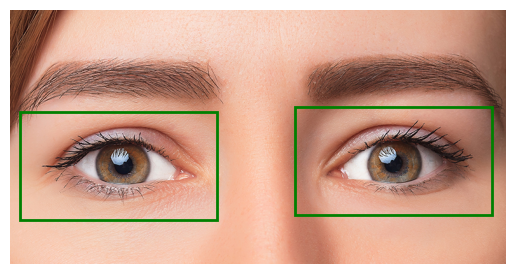

Processing: eyes_dark.jpg


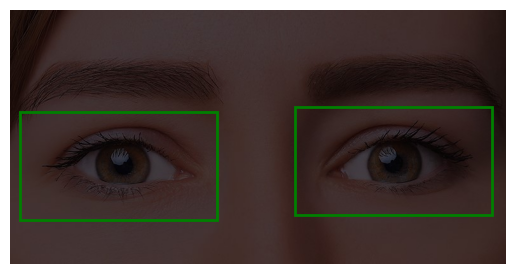

Processing: glazenki.jpg


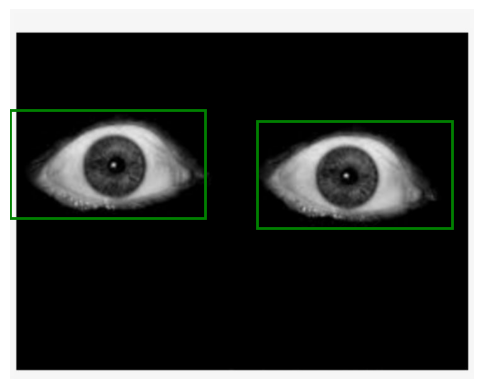

Processing: woman.jpg


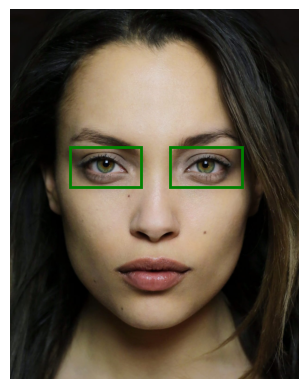

Finished processing images.


In [10]:
import cv2
import numpy as np
from skimage.feature import hog
import os
import matplotlib.pyplot as plt

image_directory = "hog"
template_filename = "eye.png"
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
correlation_threshold = 0.6

def LoadImagesFromFolder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            try:
                img = cv2.imread(os.path.join(folder, filename))
                if img is not None:
                    images.append((filename, img))
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue
    return images


def ExtractHogFeatures(image, orientations, pixels_per_cell, cells_per_block):
    try:
        fd, hog_image = hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=True,
            channel_axis=None,
        )
        return fd, hog_image
    except Exception as e:
        print(f"HOG extraction failed: {e}")
        return None, None


def CrossCorrelation(image_hog, template_hog):
    pad_rows, pad_cols = template_hog.shape[0] - 1, template_hog.shape[1] - 1
    padded_image_hog = np.pad(
        image_hog, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode="constant"
    )
    try:
        correlation = cv2.filter2D(padded_image_hog, -1, template_hog)
        return correlation
    except Exception as e:
        print(f"Cross-correlation failed: {e}")
        return None


def FindTemplate(image, template, orientations, pixels_per_cell, cells_per_block):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image_fd, image_hog = ExtractHogFeatures(
        image, orientations, pixels_per_cell, cells_per_block
    )

    if image_fd is None or image_hog is None:
        return None

    template_fd, template_hog = ExtractHogFeatures(
        template, orientations, pixels_per_cell, cells_per_block
    )

    if template_fd is None or template_hog is None:
        return None

    if template_hog.shape > image_hog.shape:
        print("Template larger than image.")
        return None

    correlation_result = CrossCorrelation(image_hog, template_hog)
    if correlation_result is None:
        return None

    _, max_val, _, max_loc = cv2.minMaxLoc(correlation_result)
    pad_rows, pad_cols = template_hog.shape[0] - 1, template_hog.shape[1] - 1
    top_left = (max_loc[0] - pad_cols, max_loc[1] - pad_rows)

    return (
        top_left,
        template.shape[1],
        template.shape[0],
        max_val,
        image_hog,
        correlation_result,
    )


def ShowEye(image, coods):
    """Displays the image with a rectangle using matplotlib."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    _, ax = plt.subplots(1)
    ax.imshow(image)
    for top_left, bottom_right in coods:
        rect = plt.Rectangle(
            top_left,
            bottom_right[0] - top_left[0],
            bottom_right[1] - top_left[1],
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)
    ax.axis('off')
    plt.show()

images = LoadImagesFromFolder(image_directory)
template = cv2.imread(os.path.join(image_directory, template_filename), cv2.IMREAD_GRAYSCALE)

if template is None:
    print("Template not found.")
    exit()

if not images:
    print("No images found.")
    exit()

# Use flipped template to find another eye
template_flipped = cv2.flip(template, 1)

for filename, image in images:
    print(f"Processing: {filename}")

    if image is None:
        print(f"Could not load {filename}")
        continue
        
    eye_coords = []
    original_image = image.copy()

    results = FindTemplate(image, template, orientations, pixels_per_cell, cells_per_block)

    x1 = results[0][0] - results[1] // 2
    x2 = x1 + results[1]
    image[:, x1:x2] = 0

    results_flipped = FindTemplate(image, template_flipped, orientations, pixels_per_cell, cells_per_block)

    image = original_image.copy()

    for result in (results, results_flipped):
        if result:
            (center, template_width, template_height, max_correlation, image_hog, correlation_result) = result
            top_left = (center[0] - template_width // 2, center[1] - template_height // 2)
            bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

            if max_correlation > correlation_threshold:
                eye_coords.append((top_left, bottom_right))
            elif result == results:
                print(f"No found eye by template, max correlation: {max_correlation}")
            else:
                print(f"No found eye by flipped template, max correlation: {max_correlation}")

    ShowEye(image, eye_coords)

    if not results and not results_flipped:
        print(f"Not found eye in {filename}")

print("Finished processing images.")